### RUL PREDICTION USING LSTM

#### Import Libraries

In [482]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from time import sleep
from os import listdir
import matplotlib.image as mpimg
from matplotlib.animation import FuncAnimation as FA
from matplotlib.animation import PillowWriter

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

#### Import Datasets

In [387]:
folder_path = './Dataset/'

listdir(folder_path)

file_name = 'FD001.txt'

df_train = pd.read_csv(folder_path + 'train_' + file_name, header = None, sep = ' ')
df_test = pd.read_csv(folder_path + 'test_'+file_name, header = None, sep = ' ')
rul_test = pd.read_csv(folder_path + 'RUL_'+file_name, header = None)

for df in [df_train, df_test, rul_test]:
    display(df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,NaN,NaN
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,NaN,NaN
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,NaN,NaN
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,NaN,NaN
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,NaN,NaN


,0
0,112
1,98
2,69
3,82
4,91


In [389]:
col_names = []

col_names.append('unit')
col_names.append('time')

for i in range(1,4):
    col_names.append('os'+str(i))
for i in range(1,22):
    col_names.append('s'+str(i))

df_train = df_train.iloc[:,:-2].copy()
df_train.columns = col_names
display(df_train.head())

df_test = df_test.iloc[:,:-2].copy()
df_test.columns = col_names
display(df_test.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


Attaching RUL(remaining useful lifetime) values to the datasets.

In [392]:
rul_list = []
engine_numbers = max(df_train['unit'])
for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_train[df_train['unit'] == n]['time'])
    length = len(time_list)
    rul = list(length - time_list)
    rul_list += rul
    
df_train['rul'] = rul_list

rul_list = []

for n in np.arange(1,engine_numbers+1):
    
    time_list = np.array(df_test[df_test['unit'] == n]['time'])
    length = len(time_list)
    rul_val = rul_test.iloc[n-1].item()
    rul = list(length - time_list + rul_val)
    rul_list += rul

df_test['rul'] = rul_list

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187


,unit,time,os1,os2,os3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,rul
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138


Previously mentioned columns are dropped.

In [395]:
drop_cols1 = ['os3','s1','s5','s6','s10','s16','s18','s19']

df_train = df_train.drop(drop_cols1, axis = 1)
df_test = df_test.drop(drop_cols1, axis = 1)

for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,191
1,1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,190
2,1,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,189
3,1,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,188
4,1,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.0023,0.0003,643.02,1585.29,1398.21,553.90,2388.04,9050.17,47.20,521.72,2388.03,8125.55,8.4052,392,38.86,23.3735,142
1,1,2,-0.0027,-0.0003,641.71,1588.45,1395.42,554.85,2388.01,9054.42,47.50,522.16,2388.06,8139.62,8.3803,393,39.02,23.3916,141
2,1,3,0.0003,0.0001,642.46,1586.94,1401.34,554.11,2388.05,9056.96,47.50,521.97,2388.03,8130.10,8.4441,393,39.08,23.4166,140
3,1,4,0.0042,0.0000,642.44,1584.12,1406.42,554.07,2388.03,9045.29,47.28,521.38,2388.05,8132.90,8.3917,391,39.00,23.3737,139
4,1,5,0.0014,0.0000,642.51,1587.19,1401.92,554.16,2388.01,9044.55,47.31,522.15,2388.03,8129.54,8.4031,390,38.99,23.4130,138


Min-Max Scaling

In [398]:
minmax_dict = {}

for c in df_train.columns:
    if 's' in c:
        minmax_dict[c+'min'] = df_train[c].min()
        minmax_dict[c+'max']=  df_train[c].max()
        
for c in df_train.columns:
    if 's' in c:
        df_train[c] = (df_train[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for c in df_test.columns:
    if 's' in c:
        df_test[c] = (df_test[c] - minmax_dict[c+'min']) / (minmax_dict[c+'max'] - minmax_dict[c+'min'])
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.609195,0.250000,0.283133,0.453019,0.352633,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.252874,0.750000,0.343373,0.369523,0.370527,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.540230,0.500000,0.343373,0.256159,0.331195,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.390805,0.333333,0.349398,0.257467,0.404625,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.344828,0.250000,0.150602,0.379551,0.222316,0.805153,0.166667,0.146684,0.386905,0.739872,0.264706,0.204768,0.213159,0.416667,0.682171,0.686827,141
2,1,3,0.517241,0.583333,0.376506,0.346632,0.322248,0.685990,0.227273,0.158081,0.386905,0.699360,0.220588,0.155640,0.458638,0.416667,0.728682,0.721348,140
3,1,4,0.741379,0.500000,0.370482,0.285154,0.408001,0.679549,0.196970,0.105717,0.255952,0.573561,0.250000,0.170090,0.257022,0.250000,0.666667,0.662110,139
4,1,5,0.580460,0.500000,0.391566,0.352082,0.332039,0.694042,0.166667,0.102396,0.273810,0.737740,0.220588,0.152751,0.300885,0.166667,0.658915,0.716377,138


Smoothing

In [401]:
def smooth(s, b = 0.98):

    v = np.zeros(len(s)+1) #v_0 is already 0.
    bc = np.zeros(len(s)+1)

    for i in range(1, len(v)): #v_t = 0.95
        v[i] = (b * v[i-1] + (1-b) * s[i-1]) 
        bc[i] = 1 - b**i

    sm = v[1:] / bc[1:]
    
    return sm

s = [1,2,3,4,5]
print(s)
print(f'After Smoothing: {smooth(s)}')

[1, 2, 3, 4, 5]
After Smoothing: [1.         1.50505051 2.01346756 2.52525046 3.04039827]


In [403]:
for c in df_train.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_train[df_train['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_train[c+'_smoothed'] = sm_list
        
for c in df_test.columns:
    
    if 's' in c:
        sm_list = []

        for n in np.arange(1,101):
            s = np.array(df_test[df_test['unit'] == n][c].copy())
            sm = list(smooth(s, 0.98))
            sm_list += sm
        
        df_test[c+'_smoothed'] = sm_list

Let's take a look at how smoothed values (salmon) look compared to the original series (lightblue), for a particular sensor (unit 10 from train)

In [406]:
df_train.columns

Index(['unit', 'time', 'os1', 'os2', 's2', 's3', 's4', 's7', 's8', 's9', 's11',
       's12', 's13', 's14', 's15', 's17', 's20', 's21', 'rul', 'os1_smoothed',
       'os2_smoothed', 's2_smoothed', 's3_smoothed', 's4_smoothed',
       's7_smoothed', 's8_smoothed', 's9_smoothed', 's11_smoothed',
       's12_smoothed', 's13_smoothed', 's14_smoothed', 's15_smoothed',
       's17_smoothed', 's20_smoothed', 's21_smoothed'],
      dtype='object')

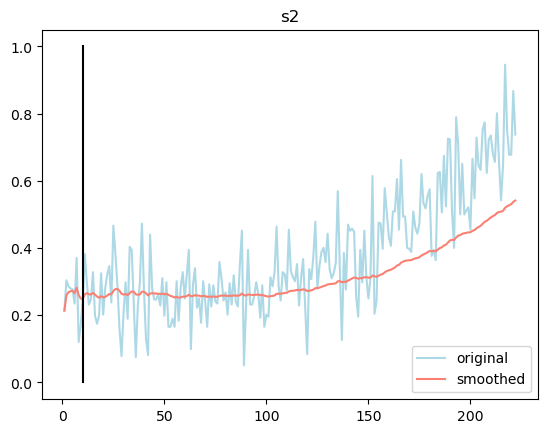

In [408]:
sample = 10
sample_df = df_train[df_train['unit'] == sample].copy()

# fig, axes = plt.subplots(6,3, figsize = (15,25))
fig = plt.figure()
# fig.tight_layout()

j = -1
c = 's2'
plt.plot(sample_df['time'], sample_df[c], c = 'lightblue', label = 'original')
plt.plot(sample_df['time'], sample_df[c+'_smoothed'], c = 'salmon', label = 'smoothed')
plt.plot([10,10],[0,1], c = 'black')
plt.title(c)
plt.legend()

Remove the original series


In [411]:
for c in df_train.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_train[c] = df_train[c+'_smoothed']
        df_train.drop(c+'_smoothed', axis = 1, inplace = True)
        
for c in df_test.columns:
    if ('s' in c) and ('smoothed' not in c):
        df_test[c] = df_test[c+'_smoothed']
        df_test.drop(c+'_smoothed', axis = 1, inplace = True)
        
for df in [df_train, df_test]:
    display(df.head())

,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.459770,0.166667,0.183735,0.406802,0.309757,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.535237,0.208754,0.233936,0.430144,0.331412,0.676638,0.227120,0.104951,0.375060,0.700028,0.243018,0.181025,0.387888,0.333333,0.689688,0.727870,190
2,1,3,0.439208,0.392826,0.271154,0.409527,0.344714,0.688033,0.242630,0.116885,0.332528,0.732432,0.235390,0.177885,0.377535,0.276652,0.668677,0.691652,189
3,1,4,0.465234,0.420437,0.289760,0.370016,0.341231,0.701612,0.262094,0.118852,0.289798,0.772801,0.250520,0.177113,0.323193,0.291254,0.644194,0.684112,188
4,1,5,0.449741,0.402305,0.302174,0.346587,0.354428,0.694673,0.258000,0.125327,0.282753,0.767278,0.247350,0.176618,0.339614,0.317360,0.632735,0.688357,187


,unit,time,os1,os2,s2,s3,s4,s7,s8,s9,s11,s12,s13,s14,s15,s17,s20,s21,rul
0,1,1,0.632184,0.750000,0.545181,0.310661,0.269413,0.652174,0.212121,0.127614,0.208333,0.646055,0.220588,0.132160,0.308965,0.333333,0.558140,0.661834,142
1,1,2,0.487054,0.497475,0.345899,0.345454,0.245626,0.729436,0.189164,0.137245,0.298521,0.693438,0.242870,0.168831,0.260578,0.375421,0.620781,0.674457,141
2,1,3,0.497321,0.526674,0.356308,0.345854,0.271685,0.714661,0.202125,0.144331,0.328579,0.695452,0.235292,0.164345,0.327936,0.389448,0.657477,0.690404,140
3,1,4,0.560197,0.519802,0.359960,0.330216,0.306804,0.705615,0.200797,0.134383,0.309869,0.664050,0.239081,0.165825,0.309667,0.353523,0.659845,0.683115,139
4,1,5,0.564415,0.515680,0.366539,0.334768,0.312057,0.703206,0.193692,0.127725,0.302363,0.679389,0.235232,0.163103,0.307839,0.314626,0.659651,0.690038,138


 When we look at the length of the trajectories for each unit in both the training and test sets, thus 200 engines, we see that for the training set that had the entire trajectories, have minimum length of 128. However, for the test set, we have a minimum value of 31. This means that if we were to predict the final RUL for every test engine unit, we cannot use a window size greater than 31 for training the model. Furthermore, if you take a look at the smoothed series visualization, I put a black vertical line for every graph, at about time step 10. This is because, when we smooth using exponentially weighted averages, seems like in the beginning, it seems a little shaky. Thus, I will be taking that part out of the training process. This will happen for test data as well. Thus, the maximum window size we can take is 31 - 10 = 21. I will go with 20.

In [414]:
print('training set time cycles:')
display(df_train.groupby('unit')['time'].max().describe())
print('test set time cycles:')
display(df_test.groupby('unit')['time'].max().describe())

training set time cycles:


count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: time, dtype: float64

test set time cycles:


count    100.000000
mean     130.960000
std       53.593479
min       31.000000
25%       88.750000
50%      133.500000
75%      164.250000
max      303.000000
Name: time, dtype: float64

In [416]:

n_features = len([c for c in df_train.columns if 's' in c]) #plus one for time
window = 20
print(f'number of features: {n_features}, window size: {window}')

number of features: 16, window size: 20


 Splitting Train and Validation Sets: Out of the 100 engines in the training set, I will randomly take out 20 engines for validation.

In [419]:
np.random.seed(5)
units = np.arange(1,101)
train_units = list(np.random.choice(units, 80, replace = False))
val_units = list(set(units) - set(train_units))
print(val_units)

[8, 9, 16, 17, 28, 31, 45, 54, 62, 63, 66, 74, 76, 77, 78, 79, 81, 91, 93, 100]


Prepare Training, Validation and Test Dataloaders.

For training process, I will take batches of 64.
For the validation process, I will take the entire validation set (all the windows avaiable). For the test process, I will take the LAST window of each engine's given trajectory, thus it will have exactly 100 X(size 20 window)s and 100 y(RUL)s.

In [422]:
train_data = df_train[df_train['unit'].isin(train_units)].copy()
val_data = df_train[df_train['unit'].isin(val_units)].copy()

train_indices = list(train_data[(train_data['rul'] >= (window - 1)) & (train_data['time'] > 10)].index)
val_indices = list(val_data[(val_data['rul'] >= (window - 1)) & (val_data['time'] > 10)].index)

In [424]:
class data(Dataset):
    
    def __init__(self, list_indices, df_train):
        
        self.indices = list_indices
        self.df_train = df_train
        
    def __len__(self):
        
        return len(self.indices)
    
    def __getitem__(self, idx):
        
        ind = self.indices[idx]
        X_ = self.df_train.iloc[ind : ind + 20, :].drop(['time','unit','rul'], axis = 1).copy().to_numpy()
        y_ = self.df_train.iloc[ind + 19]['rul']
        
        return X_, y_
    
torch.manual_seed(5)
    
train = data(train_indices, df_train)
val = data(val_indices, df_train)

trainloader = DataLoader(train, batch_size = 64, shuffle = True)
valloader = DataLoader(val, batch_size = len(val_indices), shuffle = True)

units = np.arange(1,101)

class test(Dataset):
    
    def __init__(self, units, df_test):
        
        self.units = units
        self.df_test = df_test
        
    def __len__(self):
        
        return len(self.units)
    
    def __getitem__(self, idx):
        
        n = self.units[idx]
        U = self.df_test[self.df_test['unit'] == n].copy()
        X_ = U.reset_index().iloc[-20:,:].drop(['time','index','unit','rul'], axis = 1).copy().to_numpy()
        y_ = U['rul'].min()
        
        return X_, y_
    
test = test(units, df_test)
testloader = DataLoader(test, batch_size = 100)

In [426]:
dataiter = iter(trainloader)
x,y = next(dataiter)
x.shape

torch.Size([64, 20, 16])

### 2. Model Building and Training

I will be using a LSTM Model, with some linear - relu layers before the final output.

In [432]:
## Custom loss function
class CustomLoss(nn.Module):
    def __init__(self, alpha):
        super(CustomLoss, self).__init__()
        self.alpha = alpha

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2) + self.alpha*(torch.mean(torch.relu(predictions-targets)))

In [434]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cuda'
# device = 'cpu'


class LSTMRegressor(nn.Module):
    
    def __init__(self, n_features, hidden_units):
        super().__init__()
        self.n_features = n_features
        self.hidden_units = hidden_units
        self.n_layers = 1
        self.lstm = nn.LSTM(input_size = n_features, hidden_size = self.hidden_units, batch_first = True, num_layers = self.n_layers)
        self.linear1 = nn.Linear(in_features=self.hidden_units, out_features=12)
        self.relu1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=12, out_features=12)
        self.relu2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=12, out_features=1)
        
    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        c0 = torch.zeros(self.n_layers, batch_size, self.hidden_units,device=x.device).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear1(hn[0])
        out = self.relu1(out)
        out = self.linear2(out)
        out = self.relu2(out)
        out = self.linear3(out).flatten()
        
        return out
    
learning_rate = 0.001
n_hidden_units = 12

torch.manual_seed(15)

model = LSTMRegressor(n_features, n_hidden_units).to(device)
# loss_fn = nn.MSELoss()
alpha = 0.4
loss_fn = CustomLoss(alpha)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                             
ks = [key for key in model.state_dict().keys() if 'linear' in key and '.weight' in key]

for k in ks:
    nn.init.kaiming_uniform_(model.state_dict()[k])
    
bs = [key for key in model.state_dict().keys() if 'linear' in key and '.bias' in key]

for b in bs:
    nn.init.constant_(model.state_dict()[b], 0)

 Validation and Test Functions

In [437]:
def validation():
    
    model.eval()
    X, y = next(iter(valloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        val_loss = loss_fn(y_pred, y).item()
        
    return val_loss

loss_L1 = nn.L1Loss()
    
def test():
    model.eval()
    X, y = next(iter(testloader))
    X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
    
    with torch.no_grad():
        y_pred = model(X)
        # y_pred = torch.round(y_pred)
        test_loss_MSE = torch.mean((y_pred - y) ** 2).item() #loss_fn(y_pred, y).item()
        test_loss_L1 = loss_L1(y_pred, y).item()
        test_ASUE = (torch.mean(torch.relu(y-y_pred))).item()
        
    return test_loss_MSE, test_loss_L1, test_ASUE, y_pred, y

Training Loop: I have trained using Adam Optimizer for 35 epochs with learning rate = 0.001

In [442]:
T = []
V = []
epochs = 35

loss_fn = nn.MSELoss()
for i in tqdm(range(epochs)):
    
    L = 0
    model.train()
    
    for batch, (X,y) in enumerate(trainloader):
        
        X, y = X.to(device).to(torch.float32), y.to(device).to(torch.float32)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        L += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # alpha = alpha*(1 +((y<y_pred).count_nonzero().item()/len(y)+0.5))
        # loss_fn = CustomLoss(alpha)
        # print(alpha)
    val_loss = validation()
    
    T.append(L/len(trainloader))
    V.append(val_loss)
    (y<y_pred).count_nonzero().item()/len(y)
    # if (i+1) % 10 == 0:
    #     sleep(0.5)
    print(f'epoch:{i+1}, avg_train_loss:{L/len(trainloader)}, val_loss:{val_loss}')
    

  3%|▎         | 1/35 [00:13<07:47, 13.76s/it]

epoch:1, avg_train_loss:10049.261820295216, val_loss:3915.9013671875


  6%|▌         | 2/35 [00:27<07:42, 14.02s/it]

epoch:2, avg_train_loss:4260.046773454785, val_loss:3120.121337890625


  9%|▊         | 3/35 [00:42<07:31, 14.10s/it]

epoch:3, avg_train_loss:4010.007345824115, val_loss:3115.759765625


 11%|█▏        | 4/35 [00:57<07:33, 14.64s/it]

epoch:4, avg_train_loss:4003.718921762652, val_loss:3102.816162109375


 14%|█▍        | 5/35 [01:12<07:20, 14.67s/it]

epoch:5, avg_train_loss:3386.567601566821, val_loss:2014.5340576171875


 17%|█▋        | 6/35 [01:26<07:02, 14.56s/it]

epoch:6, avg_train_loss:2313.4664004165516, val_loss:1462.53125


 20%|██        | 7/35 [01:40<06:40, 14.32s/it]

epoch:7, avg_train_loss:2175.818859809268, val_loss:1531.1617431640625


 23%|██▎       | 8/35 [01:54<06:23, 14.21s/it]

epoch:8, avg_train_loss:2055.067113555638, val_loss:1528.8001708984375


 26%|██▌       | 9/35 [02:08<06:08, 14.17s/it]

epoch:9, avg_train_loss:1920.7495870674607, val_loss:1090.041259765625


 29%|██▊       | 10/35 [02:22<05:52, 14.08s/it]

epoch:10, avg_train_loss:1661.8226172523161, val_loss:1012.53564453125


 31%|███▏      | 11/35 [02:36<05:37, 14.06s/it]

epoch:11, avg_train_loss:1461.2567349324183, val_loss:918.3101806640625


 34%|███▍      | 12/35 [02:50<05:23, 14.07s/it]

epoch:12, avg_train_loss:1315.7582593259558, val_loss:976.488037109375


 37%|███▋      | 13/35 [03:04<05:08, 14.00s/it]

epoch:13, avg_train_loss:1195.2359362576915, val_loss:784.7542114257812


 40%|████      | 14/35 [03:18<04:51, 13.90s/it]

epoch:14, avg_train_loss:1111.1057010076743, val_loss:878.604248046875


 43%|████▎     | 15/35 [03:32<04:39, 13.95s/it]

epoch:15, avg_train_loss:1050.6402809345616, val_loss:894.3885498046875


 46%|████▌     | 16/35 [03:46<04:28, 14.13s/it]

epoch:16, avg_train_loss:994.6802840781423, val_loss:693.9164428710938


 49%|████▊     | 17/35 [04:01<04:18, 14.34s/it]

epoch:17, avg_train_loss:935.075257292891, val_loss:773.5265502929688


 51%|█████▏    | 18/35 [04:15<04:00, 14.15s/it]

epoch:18, avg_train_loss:970.2159061938261, val_loss:794.5554809570312


 54%|█████▍    | 19/35 [04:29<03:44, 14.04s/it]

epoch:19, avg_train_loss:913.7242018438019, val_loss:774.9446411132812


 57%|█████▋    | 20/35 [04:43<03:30, 14.05s/it]

epoch:20, avg_train_loss:915.3680509044005, val_loss:870.5393676757812


 60%|██████    | 21/35 [04:56<03:14, 13.86s/it]

epoch:21, avg_train_loss:881.2662915255116, val_loss:811.654541015625


 63%|██████▎   | 22/35 [05:10<03:00, 13.87s/it]

epoch:22, avg_train_loss:880.1048359828712, val_loss:668.3567504882812


 66%|██████▌   | 23/35 [05:24<02:45, 13.81s/it]

epoch:23, avg_train_loss:851.7529321181036, val_loss:706.9654541015625


 69%|██████▊   | 24/35 [05:37<02:31, 13.81s/it]

epoch:24, avg_train_loss:818.1415206774146, val_loss:720.2178344726562


 71%|███████▏  | 25/35 [05:51<02:17, 13.78s/it]

epoch:25, avg_train_loss:866.56674234846, val_loss:666.6550903320312


 74%|███████▍  | 26/35 [06:05<02:03, 13.75s/it]

epoch:26, avg_train_loss:855.590651115485, val_loss:813.911865234375


 77%|███████▋  | 27/35 [06:19<01:49, 13.75s/it]

epoch:27, avg_train_loss:843.7357146676662, val_loss:677.5352172851562


 80%|████████  | 28/35 [06:32<01:36, 13.73s/it]

epoch:28, avg_train_loss:841.2875174463322, val_loss:760.2857055664062


 83%|████████▎ | 29/35 [06:46<01:22, 13.73s/it]

epoch:29, avg_train_loss:809.7036184125242, val_loss:748.1734008789062


 86%|████████▌ | 30/35 [07:00<01:08, 13.73s/it]

epoch:30, avg_train_loss:789.5172314939246, val_loss:665.5614624023438


 89%|████████▊ | 31/35 [07:13<00:54, 13.75s/it]

epoch:31, avg_train_loss:809.3419050368587, val_loss:752.4154052734375


 91%|█████████▏| 32/35 [07:27<00:41, 13.70s/it]

epoch:32, avg_train_loss:817.1653103448648, val_loss:790.9937133789062


 94%|█████████▍| 33/35 [07:41<00:27, 13.72s/it]

epoch:33, avg_train_loss:803.1465882157858, val_loss:785.92626953125


 97%|█████████▋| 34/35 [07:54<00:13, 13.69s/it]

epoch:34, avg_train_loss:790.1450145350093, val_loss:1069.9281005859375


100%|██████████| 35/35 [08:08<00:00, 13.96s/it]

epoch:35, avg_train_loss:793.9239848989301, val_loss:688.4714965820312


In [454]:
torch.save(model.state_dict(), f'C:\\Users\\maide\\OneDrive\\Masaüstü\\staj\\Aircraft-Sensor-and-Engine-Performance\\LSTM_{alpha}')

In [456]:
mse, l1,asue, y_pred, y = test()

print(f'Test MSE:{round(mse,2)}, L1:{round(l1,2)}, ASUE:{round(asue,2)}')
print(f'MSE of overesitmated: {round(torch.mean(1*(y_pred>y)*(y_pred - y) ** 2).item(),2)}')

Test MSE:684.94, L1:18.7, ASUE:3.38
MSE of overesitmated: 610.04


In [458]:
asue

3.383119583129883

In [460]:
print(y)
print(y_pred)
print(1*(y_pred>y))

tensor([112.,  98.,  69.,  82.,  91.,  93.,  91.,  95., 111.,  96.,  97., 124.,
         95., 107.,  83.,  84.,  50.,  28.,  87.,  16.,  57., 111., 113.,  20.,
        145., 119.,  66.,  97.,  90., 115.,   8.,  48., 106.,   7.,  11.,  19.,
         21.,  50., 142.,  28.,  18.,  10.,  59., 109., 114.,  47., 135.,  92.,
         21.,  79., 114.,  29.,  26.,  97., 137.,  15., 103.,  37., 114., 100.,
         21.,  54.,  72.,  28., 128.,  14.,  77.,   8., 121.,  94., 118.,  50.,
        131., 126., 113.,  10.,  34., 107.,  63.,  90.,   8.,   9., 137.,  58.,
        118.,  89., 116., 115., 136.,  28.,  38.,  20.,  85.,  55., 128., 137.,
         82.,  59., 117.,  20.])
tensor([105.5165, 144.4919,  67.0938,  84.6043,  72.9764, 119.9787, 108.2413,
         93.7525, 129.6489,  89.4285,  81.2545, 106.7600,  87.3475, 128.6240,
        108.2002, 104.0668,  60.3657,  43.4996, 109.5560,  22.3537,  80.8139,
        168.5625, 133.7572,  14.6938, 152.9305, 179.3176,  69.2991, 123.5467,
         94.571

(0.0, 200.0)

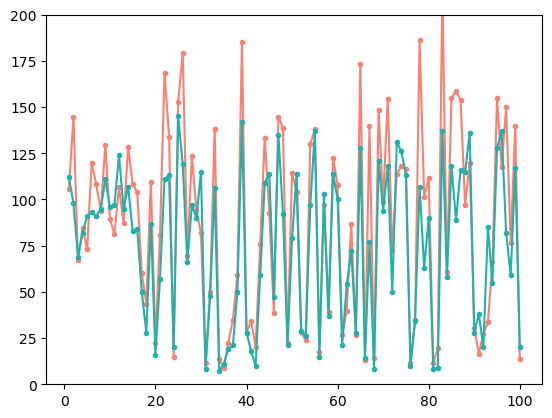

In [462]:
# fig, ax = plt.subplots( figsize = (14,8))
# plt.subplot(1,2,1)
plt.plot(np.arange(1,101), y_pred.cpu().numpy(), label = 'predictions', c = 'salmon', marker = '.')
ax1 = plt.gca()
ax1.set_ylim([0, 200])


plt.plot(np.arange(1,101), y.cpu().numpy(), label = 'true values', c = 'lightseagreen', marker = '.')
ax2 = plt.gca()
ax2.set_ylim([0, 200])

# # plt.set_xlabel('Test Engine Units', fontsize = 16)
# # plt.set_ylabel('RUL', fontsize = 16)
# ax.grid(True)
# ax.legend()
# plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

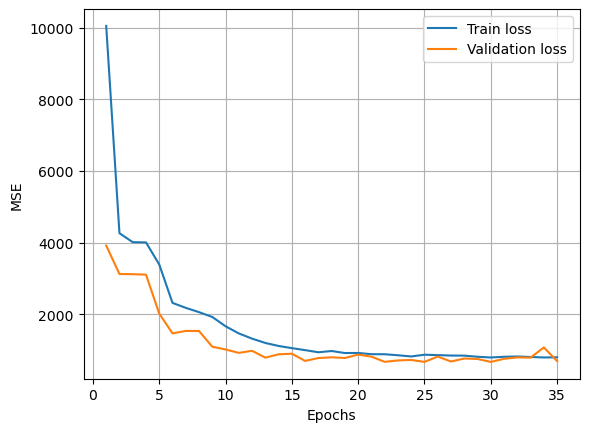

In [464]:
plt.plot(np.arange(1,len(T)+1), T, label= 'Train loss')
plt.plot(np.arange(1,len(V)+1), V, label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show

In [484]:
fig, ax = plt.subplots(figsize = (12,8))

def animate(i):
    ax.clear()
    line1, = ax.plot(np.arange(1,i+1), T[:i], label = 'train_loss')
    line2, = ax.plot(np.arange(1,i+1), V[:i], label = 'val_loss')
    ax.legend()
    ax.grid(True)
    ax.set_xlim(0,101)
    ax.set_ylim(0,4000)
    ax.set_xlabel('epochs')
    ax.set_ylabel('MSE')
                     
    return line1, line2
                     
    
animation = FA(fig, animate, np.arange(1,len(T)+1), interval = 50)

animation.save('animation3.gif', writer=PillowWriter(fps=20))

plt.close(fig)


In [488]:
from torchinfo import summary
summary(model, input_size=(64,20,16))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMRegressor                            [64]                      --
├─LSTM: 1-1                              [64, 20, 12]              1,440
├─Linear: 1-2                            [64, 12]                  156
├─ReLU: 1-3                              [64, 12]                  --
├─Linear: 1-4                            [64, 12]                  156
├─ReLU: 1-5                              [64, 12]                  --
├─Linear: 1-6                            [64, 1]                   13
Total params: 1,765
Trainable params: 1,765
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.86
Input size (MB): 0.08
Forward/backward pass size (MB): 0.14
Params size (MB): 0.01
Estimated Total Size (MB): 0.22

### 3. Prediction on Test Set

In [501]:

1*(y_pred < y)

tensor([1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
        0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 1])

In [503]:
torch.dot(y - y_pred, 1.0*(y_pred<y)).item()/len(y)

3.3831192016601563

In [505]:
torch.sum(torch.abs(y-y_pred)).item()/len(y)

18.69728515625

In [507]:
## Checking what percentage of the predictions are higher than the true values
(y<y_pred).count_nonzero().item()/len(y)

0.71